In [1]:
### Regressions Ridge et Lasso avec le package glmnet
### Outils: Ridge, Lasso, Elastic Net, Validation croisee
### Dernière mise à jour: 25/00/2020
### Jérémy L'Hour

rm(list=ls())

### PACKAGES
#install.packages("glmnet") # si glmnet n'est pas installe
library("MASS")
library("glmnet")

### FONCTIONS UTILISATEURS
source("functions/DataSim.R") # processus generateur des donnees pour les simulations

Loading required package: Matrix

Loaded glmnet 3.0-2




In [2]:
#################################
#################################
### 1. SIMULATION DES DONNEES ###
#################################
#################################

set.seed(12071990) # on fixe la graine du generateur

n = 300
data = DataSim(n=n, p=50, Ry=.2, Intercept=F)

# separation en train et test
ytrain = data$y[1:(n/2)]; Xtrain = data$X[1:(n/2),] 
ytest  = data$y[-(1:(n/2))]; Xtest = data$X[-(1:(n/2)),]

L'échantillon d'entrainement ("train") est celui qui va servir à estimer les coefficients du modèle. L'échantillon de test ("test") est celui qui va servir à estimer de façon non biaisée l'erreur de prédiction.

En ce qui concerne la séparation entre échantillons de test et d'entrainement, on n'a pas besoin de tirer aléatoirement des indices parce que les données sont simulées. Elles n'ont donc pas été ordonnées d'une quelconque façon au préalable. On va d'abord calculer les moindres carrés ordinaires, par simple souci d'obtenir un "benchmark".

In [3]:
##############
##############
### 2. MCO ###
##############
##############

mco = lm(ytrain ~ Xtrain)

# calcul de l'erreur sur le jeu de test
mco.hat = predict(mco, as.data.frame(Xtest))
print(paste("Erreur de test MCO: ",round(mean((ytest-mco.hat)^2),digits=3)))

[1] "Erreur de test MCO:  1.892"


On va commencer par calculer l'estimateur Ridge (Section 2.1) pour une valeur arbitraire de lambda. Pour cela, on utilise le package "glmnet". La fonction principale de glmnet propose un estimateur elastic-net par défaut. Le Ridge correspond au cas alpha = 0. Les notations sont cohérentes avec le document méthodologique. 

De par la nature de l'algorithme de calcul utilisé, glmnet retourne le coefficient beta pour plusieurs valeurs de lambda. Par conséquent l'attribu "beta" de l'objet glmnet retourne une matrice dont les colonnes sont les coefficients estimés pour une valeur de lambda donnée. A l'utilisateur de choisir une valeur de lambda de façon théorique. A noter, qu'il est possible alors de tracer la trajectoire des coefficients en fonction de lambda afin d'avoir une meilleure idée de la valeur de ceux-ci.

[1] "Nombre de coefficients nuls:  0"


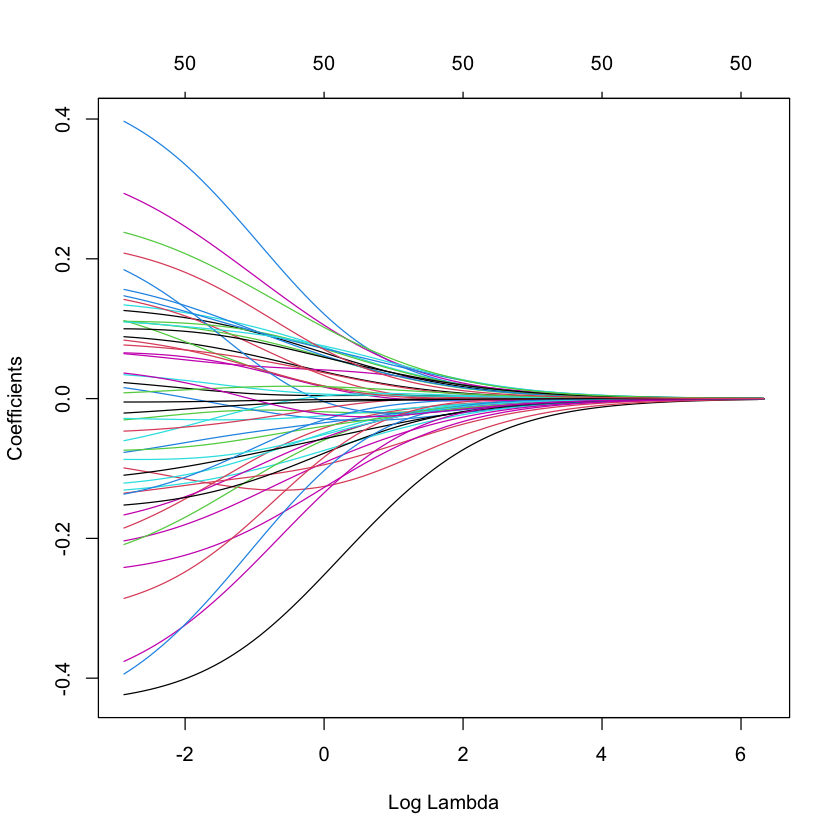

In [4]:
#####################################
#####################################
### 3. REGRESSION RIDGE (ALPHA=0) ###
#####################################
#####################################

ridge = glmnet(Xtrain, ytrain, family="gaussian", alpha=0)

# Ridge$beta est une matrice où chaque colonne collecte l'estimateur Ridge pour une valeur donnee de lambda
# Prenons une valeur arbitraire
bRidge = c(ridge$beta[,6])
print(paste("Nombre de coefficients nuls: ",sum(bRidge == 0)))
# aucun coefficient n'est strictement nul

# le package glmnet permet de visualiser la trajectoire des coefficients a mesure que lambda croit
plot(ridge, xvar="lambda")

Pour choisir la valeur de lambda qui convient, on peut mettre en oeuvre la méthode de valdiation croisée Section 2.5).

In [5]:
### Mise en oeuvre de la validation croisee pour choisir lambda
## A. de facon automatique avec le package
cv.ridge = cv.glmnet(Xtrain, ytrain, family="gaussian", alpha=0, nfolds=5)
print(paste("Lambda choisi par validation croisée = ",round(cv.ridge$lambda.min,digits=3)))

ridge.hat = predict(cv.ridge,Xtest,s="lambda.min",type="response") # donne la valeur predite sur l'échantillon de test avec la valeur de lambda qui minimise l'erreur de validation croisee
print(paste("Erreur de test Ridge, validation croisée glmnet: ",round(mean((ytest-ridge.hat)^2),digits=3)))

print("Les régresseurs ayant un coefficient non nuls sont:")
t(predict(cv.ridge,s="lambda.min",type="nonzero")) #tous!

print("Le coefficient vaut:")
predict(cv.ridge,s="lambda.min",type="coef")

[1] "Lambda choisi par validation croisée =  0.834"
[1] "Erreur de test Ridge, validation croisée glmnet:  1.014"
[1] "Les régresseurs ayant un coefficient non nuls sont:"


X1,1,2,3,4,5,6,7,8,9,10,⋯,41,42,43,44,45,46,47,48,49,50


[1] "Le coefficient vaut:"


51 x 1 sparse Matrix of class "dgCMatrix"
                       1
(Intercept)  0.601322867
V1          -0.270868760
V2          -0.128393494
V3          -0.018174660
V4          -0.027632001
V5          -0.079558327
V6          -0.099852830
V7           0.042455438
V8          -0.048615211
V9           0.021702329
V10         -0.036863432
V11          0.079189828
V12          0.041941695
V13          0.071227679
V14          0.039985313
V15         -0.067651755
V16          0.138462181
V17         -0.055587968
V18          0.020871455
V19          0.004455011
V20          0.040667046
V21          0.064928192
V22          0.067511052
V23         -0.025834940
V24         -0.062930357
V25         -0.061362599
V26         -0.098412889
V27         -0.042336561
V28          0.002832235
V29          0.001814262
V30          0.117003245
V31         -0.085464186
V32         -0.016362204
V33          0.076586685
V34         -0.036326680
V35          0.007352564
V36         -0.138218499
V37     

La fonction cv.glmnet permet de mettre en oeuvre de la validation croisée rapidement. On peut alors extraire les coefficients correspondant à la valeur de lambda qui minimise l'erreur de validation croisée. Notons que "predict" offre directement la possibilité d'extraire la réponse pour de nouvelles valeurs Xtest, sans avoir à extraire les coefficients au préalable.

On va maintenant regarder la mise en place de la validation croisée en suivant les instructions du document pour mieux comprendre.

Warning message in plot.xy(xy, type, ...):
“le type de graphe 'lines' sera tronqué au premier caractère”


[1] "Lambda CV à la main =  1.1"
[1] "Erreur de test Ridge, validation croisée à la main:  1.026"


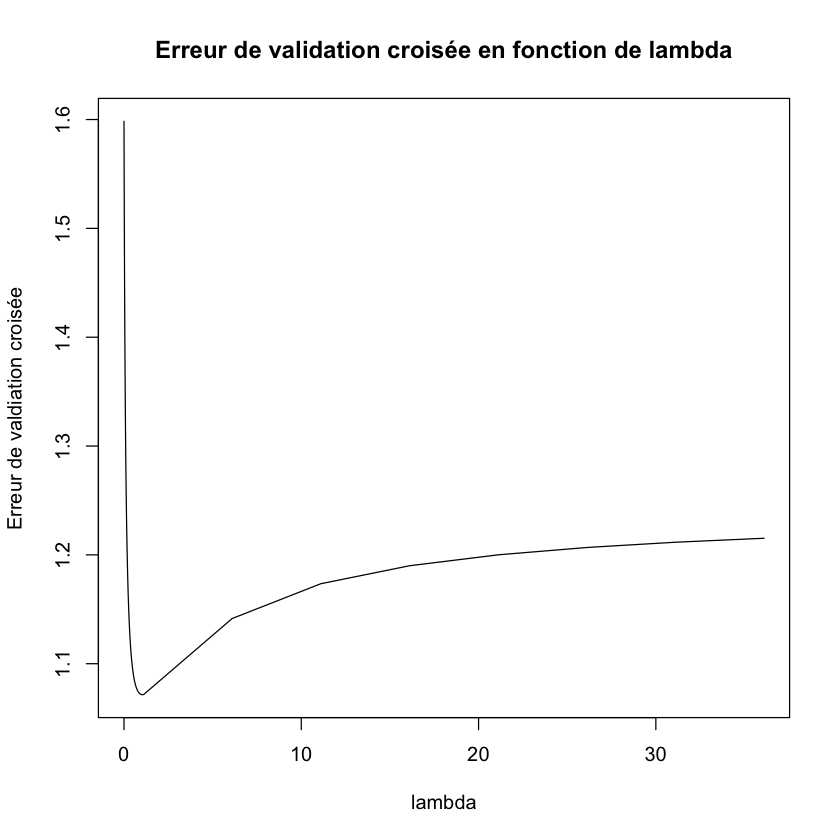

In [6]:
## B. Validation croisée "artisanale" (pour bien comprendre la validation croisee)
K = 5
lambda.set = c(seq(.001,1,by=.01),seq(1.1,40,by=5)) # ensemble des valeurs à considérer
lambda.set = sort(lambda.set,decreasing=T)

cv.group = sample(1:K,size=n/2,replace=T) # On tire le paquet dans lequel va se trouver chaque observation
cv.error = matrix(nrow=K, ncol=length(lambda.set))
for(k in 1:K){
    # separation entre les paquets
    yk = ytrain[cv.group == k];  ynk = ytrain[cv.group != k]
    Xk = Xtrain[cv.group == k,]; Xnk = Xtrain[cv.group != k,]
    
    # calcul sur les "nk"
    ridge = glmnet(Xnk,ynk, family="gaussian",alpha=0,lambda=lambda.set)
    
    # prediction sur les "k"
    ridge.hat = predict(ridge,Xk)
    
    # calcul de l'erreur
    cv.error[k,] = mapply(function(d) sum((yk-ridge.hat[,d])^2),1:ncol(ridge.hat))
}

# on aggrege les erreurs et on calcule le lambda optimal
cv.error = apply(cv.error,2,sum)/(n/2)
plot(lambda.set, cv.error, type="lines", xlab="lambda",ylab="Erreur de valdiation croisée", main="Erreur de validation croisée en fonction de lambda")
lambda.cv = lambda.set[which(cv.error==min(cv.error))]
print(paste("Lambda CV à la main = ",round(lambda.cv,digits=3)))
                          
ridge = glmnet(Xtrain,ytrain, family="gaussian",alpha=0,lambda=lambda.cv) # calcul de l'estimateur pour la valeur de lambda choisie
ridge.hat.cv = predict(ridge,Xtest)
print(paste("Erreur de test Ridge, validation croisée à la main: ",round(mean((ytest-ridge.hat.cv)^2),digits=3)))

On voit qu'il peut y avoir des différences légères entre les deux méthodes qui tiennent à la fois au partitionnement de l'échantillon (qui différe entre les deux méthodes), ainsi qu'au support des valeurs de lambda que l'on considère. Il est recommandé d'utilisé glmnet car cela est plus économe en termes de lignes de codes, mais il sera parfois nécessaire de mettre en place sa propre procédure de validation croisée.

On va maintenant voir comment mettre en place l'estimateur Lasso (Section 2.3).

[1] "Nombre de coefficients nuls:  49"
[1] "Lambda CV Lasso =  0.153"
[1] "Erreur de test Lasso:  1.012"


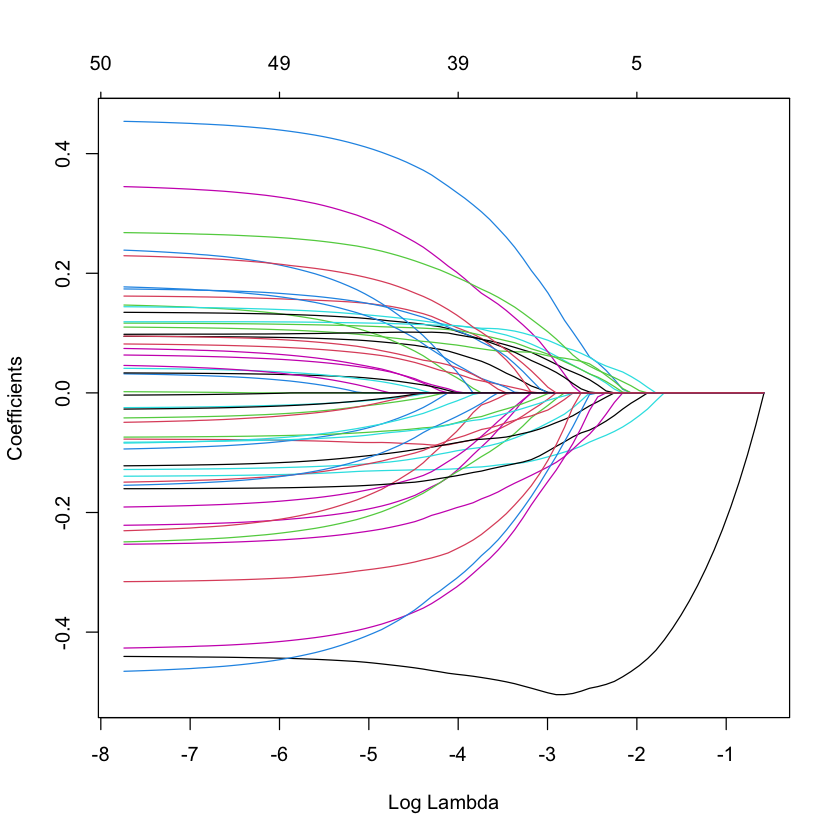

In [7]:
#####################################
#####################################
### 4. REGRESSION LASSO (ALPHA=1) ###
#####################################
#####################################

lasso = glmnet(Xtrain,ytrain, family="gaussian",alpha=1)

# Prenons une valeur arbitraire
blasso = c(lasso$beta[,6])
print(paste("Nombre de coefficients nuls: ",sum(blasso == 0)))
# plusieurs coefficients sont nuls

# on constate egalement que ce n'est pas le meme profil de regularisation
plot(lasso, xvar="lambda")

# validation croisee pour le choix du lambda
cv.lasso = cv.glmnet(Xtrain,ytrain, family="gaussian",alpha=1,nfolds=5)
print(paste("Lambda CV Lasso = ",round(cv.lasso$lambda.min,digits=3)))

lasso.hat = predict(cv.lasso,Xtest)
print(paste("Erreur de test Lasso: ",round(mean((ytest-lasso.hat)^2),digits=3)))

Contrairement au profil de régularisation pour le Ridge qui semble être différentiable à vue d'oeil (il l'est), celui du Lasso est beaucoup moins régulier. De fait, la solution n'est pas différentiable du fait de la pénalisation L-1 qui ne l'est pas.

On va maintenant voir l'estimateur Post-Lasso (Section 2.3).

In [15]:
#####################
#####################
### 5. POST-LASSO ###
#####################
#####################

# Reprenons la valeur de beta choisie par validation croisée
blasso_cv = predict(cv.lasso, type="coefficients", s="lambda.min")

print(paste("Nombre de coefficients nuls: ",sum(blasso_cv == 0)))

S_hat = which((blasso_cv[-1] !=0)) # identité des coefficients non nuls (on enlève la constante)

print("Identité des coefficients non nuls:")
print(S_hat)

# Estimateur Post-Lasso
post_lasso = lm(ytrain ~ Xtrain[,S_hat])
# calcul de l'erreur sur le jeu de test
pl.hat = predict(post_lasso, as.data.frame(Xtest[,S_hat]))
print(paste("Erreur de test Post_Lasso: ",round(mean((ytest-pl.hat)^2),digits=3)))

[1] "Nombre de coefficients nuls:  47"
[1] "Identité des coefficients non nuls:"
[1]  1  5 41
[1] "Erreur de test Post_Lasso:  1.629"


On voit que l'estimateur Post-Lasso est moins bon. Cela n'est pas étonnant car on a utilisé la valeur de lambda choisie par validation croisée pour l'estimateur Lasso. Il faudrait mettre en place une procédure similaire pour l'estimateur post-Lasso.

EXERCICE: Adapter la procédure de la validation croisée "artisanale" à l'estimateur Post-Lasso. Calculer l'erreur de test obtenue.

On va maintenant voir l'estimateur Elastic Net qui combine la pénalisation Ridge et la pénalisation Lasso (Section 2.4).

In [16]:
#####################################
#####################################
### 6. ELASTIC NET (0 < ALPHA <1) ###
#####################################
#####################################

elastic = glmnet(Xtrain,ytrain, family="gaussian",alpha=.5)

# Prenons une valeur arbitraire
belastic = c(elastic$beta[,6])
print(paste("Nombre de coefficients nuls: ",sum(belastic == 0)))
# plusieurs coefficients sont nuls egalement

cv.elastic = cv.glmnet(Xtrain,ytrain, family="gaussian",alpha=.5,nfolds=5)
elastic.hat = predict(cv.elastic,Xtest)
print(paste("Erreur de test Elastic Net: ",round(mean((ytest-elastic.hat)^2),digits=3)))

[1] "Nombre de coefficients nuls:  49"
[1] "Erreur de test Elastic Net:  1.009"


Malheureusement glmnet ne permet pas de choisir alpha avec une fonction sympathique: on peut le faire uniquement pour lambda à alpha donné.
Note: boucler sur alpha n'est pas une bonne idée car la partition de glmnet pour choisir lambda va être recalculée à chaque valeur de alpha.

Pour le faire proprement, il faut mettre la procedure de validation croisee en place soi meme.

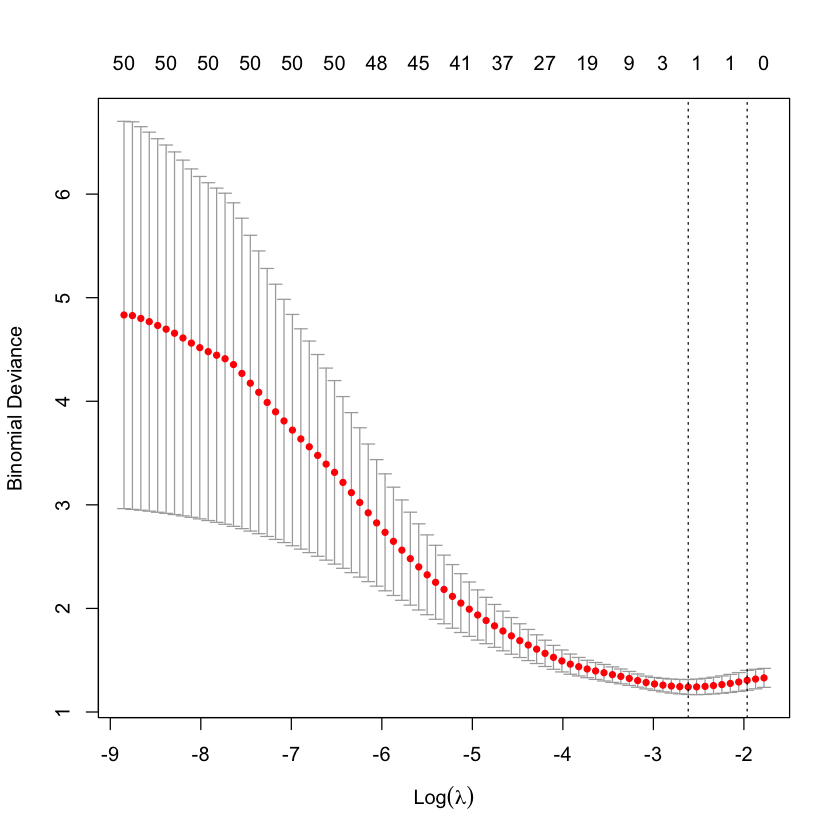

ytest_hat
  1 
150 

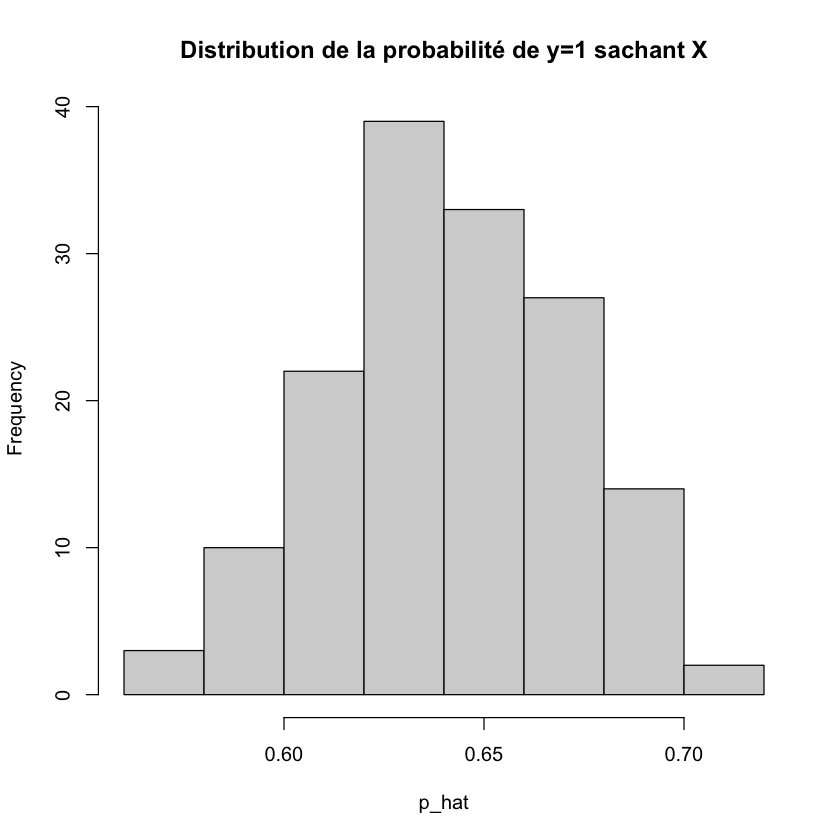

In [17]:
##########################################
##########################################
### 7. REGRESSION LOGISTIQUE PENALISEE ###
##########################################
##########################################

ytrain_bin = 1*(ytrain>0); ytest_bin = 1*(ytest>0)

logit_lasso = cv.glmnet(Xtrain,ytrain_bin,family="binomial",alpha=1,nfolds=5) # il suffit de changer l'argument "family"
plot(logit_lasso)

p_hat = predict(logit_lasso,Xtest,type="response") # predit la probabilité que y = 1 | X
hist(p_hat, main="Distribution de la probabilité de y=1 sachant X")

ytest_hat = predict(logit_lasso,Xtest,type="class") # predit la classe la plus probable
table(ytest_hat)